
# Set up the notebook

In [1]:

%pprint
import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

from StatsByUSState import (nu, ChoroplethUtilities, scu, ssu)
import pandas as pd
import re
import os
import numpy as np

Pretty printing has been turned OFF


In [2]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

def measure_semantic_interest(phrases):
    """
    Measure semantic interestingness of given phrases using a combination of 
    TF-IDF rarity and sentence embeddings.

    Args:
        phrases (list of str): A list of English phrases to evaluate.

    Returns:
        list of tuples: Each phrase paired with its "interestingness" score, sorted by score.
    """
    # Initialize a pre-trained model for sentence embeddings
    model = SentenceTransformer('all-MiniLM-L6-v2')  # Fast and lightweight embedding model

    # Step 1: Compute TF-IDF rarity for phrases
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(phrases)
    tfidf_scores = np.mean(tfidf_matrix.toarray(), axis=1)  # Average TF-IDF score per phrase

    # Step 2: Compute sentence embeddings for semantic richness
    embeddings = model.encode(phrases)
    embedding_norms = np.linalg.norm(embeddings, axis=1)  # Measure semantic richness by embedding norms

    # Step 3: Combine TF-IDF and embedding norms for "interestingness"
    interestingness_scores = tfidf_scores + embedding_norms  # Weighted sum of scores

    # Return phrases sorted by interestingness
    results = sorted(zip(phrases, interestingness_scores), key=lambda x: x[1], reverse=True)
    return results

# Example usage
phrases = [
    "The quick brown fox jumps over the lazy dog.",
    "A journey of a thousand miles begins with a single step.",
    "Artificial intelligence is transforming the world.",
    "The sun rises in the east and sets in the west.",
    "Quantum mechanics describes the behavior of particles at microscopic scales."
]

interestingness_results = measure_semantic_interest(phrases)
for phrase, score in interestingness_results:
    print(f"Phrase: {phrase}\nInterestingness Score: {score}\n")

Phrase: Quantum mechanics describes the behavior of particles at microscopic scales.
Interestingness Score: 1.0869139546284448

Phrase: The quick brown fox jumps over the lazy dog.
Interestingness Score: 1.0785007172149228

Phrase: A journey of a thousand miles begins with a single step.
Interestingness Score: 1.0783995343491846

Phrase: The sun rises in the east and sets in the west.
Interestingness Score: 1.0750697281164443

Phrase: Artificial intelligence is transforming the world.
Interestingness Score: 1.0670172745448483



In [3]:

# Categorize the US state (ask an LLM)
import cohere

# Initialize the Cohere client
co_key = ssu.secrets_json['Cohere_API_Key']
co = cohere.Client(co_key)

In [4]:

cu = ChoroplethUtilities(iso_3166_2_code='us', one_country_df=ssu.us_stats_df)

In [5]:

from IPython.display import clear_output

string_column_name = 'Cohere_Suggestion'
mask_series = ssu.us_stats_df[string_column_name].isnull()
null_states_list = ssu.us_stats_df[mask_series].index.tolist()
assert not null_states_list, print(f'US states that still have no suggestion: {nu.conjunctify_nouns(null_states_list)}')
for state in null_states_list:
    clear_output(wait=True)
    
    # Construct the prompt
    prompt = f'Categorize the state of {state} with a short description of one to four words, without a preamble (i.e. "{state} is a ", "The state of {state} is categorized as a ", etc.).'
    
    # Send the request to Cohere
    response = co.generate(
        model='command-xlarge-nightly',  # You can adjust the model as needed
        prompt=prompt,
        num_generations=5,
        max_tokens=10,  # Limit the response length
        temperature=0.7,  # Control randomness (lower value for more deterministic results)
        k=0,  # Number of most likely results to consider
        p=0.75,  # Cumulative probability for nucleus sampling
        stop_sequences=["\n"]  # Stop at a new line
    )

    # Find the most interesting of the batch
    phrases = [cgo.text.strip() for cgo in response.generations if len(cgo.text.strip().split()) <= 5]
    assert phrases, [cgo.text.strip() for cgo in response.generations]
    interestingness_results = measure_semantic_interest(phrases)
    phrase = max(interestingness_results, key=lambda x: x[1])[0]
    if phrase.endswith('.'):
        phrase = phrase[:-1]
    ssu.us_stats_df.loc[state, string_column_name] = phrase
mask_series = ssu.us_stats_df[string_column_name].isnull()
null_states_list = ssu.us_stats_df[mask_series].index.tolist()
if not null_states_list:
    nu.store_objects(us_stats_df=ssu.us_stats_df)

Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\StatsByUSState\saves\pkl\us_stats_df.pkl


In [6]:

ssu.us_stats_df[string_column_name] = ssu.us_stats_df[string_column_name].map(lambda x: x[:-1] if x.endswith('.') else x)
ssu.us_stats_df[string_column_name]

state_name
Alabama                       Southern, coastal, and culturally diverse
Alaska                                       Alaska is a Frontier State
Arizona                                    Southwestern US desert state
Arkansas                        Southern, rural, and culturally diverse
California                               West Coast economic powerhouse
Colorado                                   Mountainous Western US State
Connecticut                                     Small New England state
Delaware                                     Mid-Atlantic Coastal State
District of Columbia                  Federal district and capital city
Florida                        Peninsular state with diverse landscapes
Georgia                                     Peach State, Southern Charm
Hawaii                                            Tropical Island State
Idaho                                              Rocky Mountain state
Illinois                       Midwestern state with 

In [7]:

# Convert prompt results into strings for vectorization
ascii_regex = re.compile('[^A-Za-z0-9]+')
description_strings = ['~'.join(ascii_regex.sub(' ', s).strip().split()) for s in ssu.us_stats_df[string_column_name]]

In [8]:

from sklearn.feature_extraction.text import CountVectorizer

# Use Bag of Words (CountVectorizer) to vectorize the styles
vectorizer = CountVectorizer(tokenizer=lambda x: x.split('~'), binary=True)  # Binary Bag of Words
X = vectorizer.fit_transform(description_strings).toarray()

# Compute the number of features
num_features = X.shape[1]

print(f'Number of features: {num_features}')

Number of features: 80


In [9]:

from sklearn.decomposition import PCA

# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [10]:

from sklearn.cluster import KMeans

# Futz with n_clusters until that cluster in the corner gets labeled
kmeans = KMeans(n_clusters=4, random_state=42)
y_kmeans = kmeans.fit_predict(X_pca)

In [11]:

from collections import defaultdict

# Initialize a defaultdict to group labels by cluster
assert ssu.us_stats_df[string_column_name].shape == y_kmeans.shape, "You don't know what you're doing"
labels = ssu.us_stats_df[string_column_name].tolist()
clusters = defaultdict(list)
for label, cluster in zip(labels, y_kmeans):
    clusters[cluster].append(label)

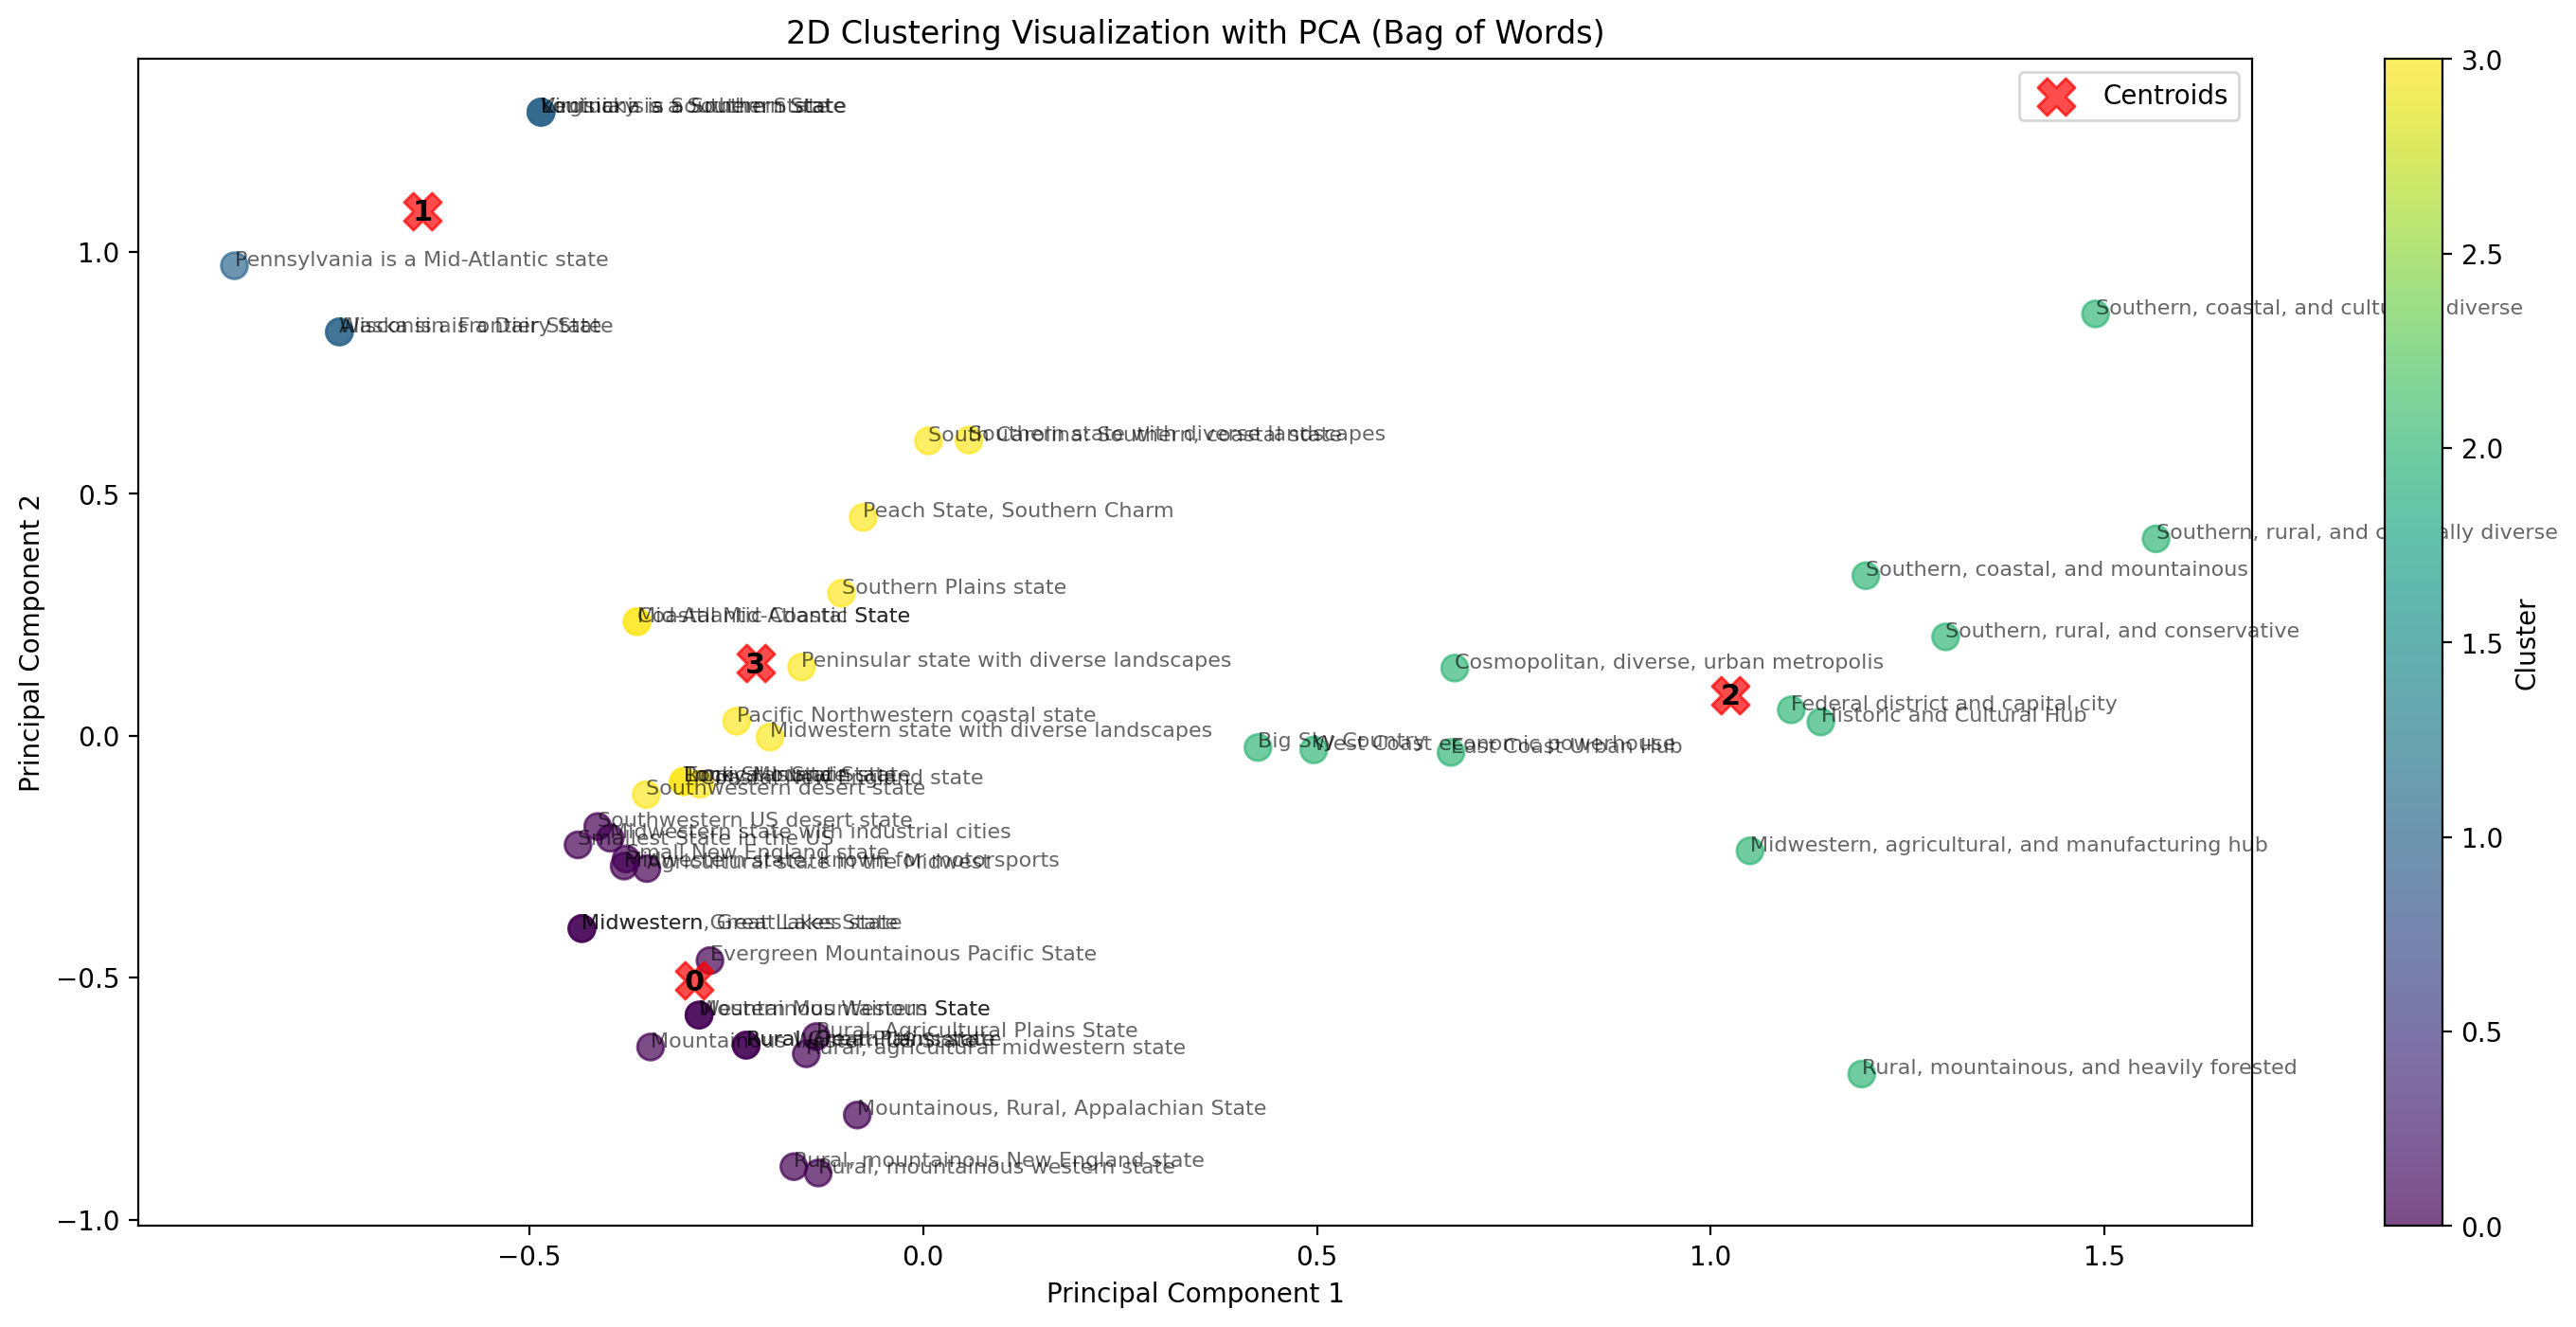

In [12]:

import matplotlib.pyplot as plt

# Make a scatter plot with the centroids labeled as big red Xs
plt.figure(figsize=(18, 8))

# Scatter plot of the data points
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='viridis', s=100, alpha=0.7)

# Scatter plot of the centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, alpha=0.7, label='Centroids')

# Add cluster numbers on top of each centroid
for i, (x, y) in enumerate(kmeans.cluster_centers_):
    plt.text(x, y - 0.02, str(i), color='black', fontsize=11, ha='center', fontweight='bold')

# Add labels to each data point (optional, depending on clarity of visualization)
for i, (x, y) in enumerate(X_pca):
    plt.text(x, y, labels[i], fontsize=8, alpha=0.6)

# Add plot details
plt.title('2D Clustering Visualization with PCA (Bag of Words)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.colorbar(scatter, label='Cluster')
plt.show()

In [13]:

cluster_dict = {}
for cluster_number, descriptions_list in clusters.items():
    print(f'\nCluster #{cluster_number}:')
    for descr in descriptions_list:
        print(descr)
        cluster_dict[descr] = cluster_number


Cluster #2:
Southern, coastal, and culturally diverse
Southern, rural, and culturally diverse
West Coast economic powerhouse
Federal district and capital city
Historic and Cultural Hub
Southern, rural, and conservative
Midwestern, agricultural, and manufacturing hub
Big Sky Country
Rural, mountainous, and heavily forested
East Coast Urban Hub
Cosmopolitan, diverse, urban metropolis
Southern, coastal, and mountainous

Cluster #1:
Alaska is a Frontier State
Kentucky is a Southern State
Louisiana is a Southern state
Pennsylvania is a Mid-Atlantic state
Virginia is a Southern State
Wisconsin is a Dairy State

Cluster #0:
Southwestern US desert state
Mountainous Western US State
Small New England state
Midwestern state, known for motorsports
Agricultural state in the Midwest
Rural, agricultural midwestern state
Midwestern Great Lakes State
Midwestern, Great Lakes state
Rural Great Plains state
Western Mountainous State
Rural, Agricultural Plains State
Midwestern state with industrial citie


## Prepare for and Create Choropleth

In [14]:

numeric_column_name = 'Cluster_Number'
if numeric_column_name not in ssu.us_stats_df.columns:
    from pandas import Series
    ssu.us_stats_df[numeric_column_name] = Series([cluster_dict[descr] for descr in ssu.us_stats_df[string_column_name]])

In [15]:

# Close the Notepad++ window after you're finished in order to completely run this cell
text_editor_path = r'C:\Program Files\Notepad++\notepad++.exe'
if (numeric_column_name in ssu.us_stats_df.columns) and (string_column_name in ssu.us_stats_df.columns):
    svg_file_path = os.path.abspath(cu.create_country_colored_labeled_map(
        numeric_column_name=numeric_column_name, string_column_name=string_column_name, one_country_df=cu.one_country_df)
    )
    !"{text_editor_path}" "{svg_file_path}"

In [ ]:

cu.get_colorbar_xml(numeric_column_name, cmap='viridis', verbose=True)

In [19]:

nu.open_path_in_notepad(r'~\OneDrive\Documents\GitHub\StatsByUSState\choropleths\../py\StatsByUSState\choropleth_utils.py')

Attempting to open C:\Users\daveb\OneDrive\Documents\GitHub\StatsByUSState\py\StatsByUSState\choropleth_utils.py


In [69]:

from os import path as osp

file_path = osp.join(cu.svg_dir, 'colorbar.svg')
print(file_path)
cu.trim_d_path(file_path)

C:\Users\daveb\OneDrive\Documents\GitHub\StatsByUSState\saves\svg\colorbar.svg
